In [1]:
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
plt.style.use("support-files/qubit.mplstyle")

MOhm = 10**6
kOhm = 10**3
uV = 10**(-6)
mV = 10**(-3)

# Auditing NPL setup
<img src="./support-files/cqps-resistance.svg"/>

## See how voltage from Vokogawa splits across the branch
The CQPS resistance will generally be either 0 or 40k$\Omega$ (in the blockade)

The following simulation shows how much of the voltage from the yokogawa will actually be experienced by the "branch"

**As we see, the CQPS changing resistance has a minor affect on the voltage across the branch**

<IPython.core.display.Javascript object>


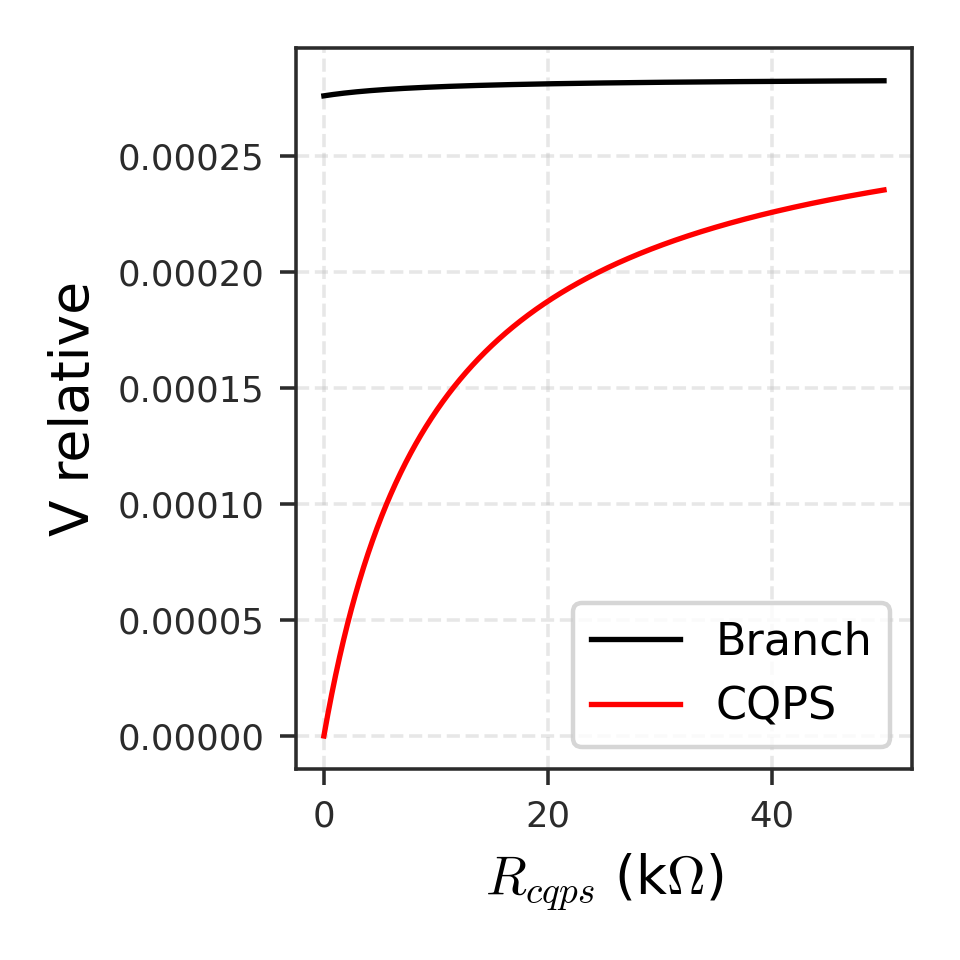

In [2]:
R1 = 1*MOhm
R2 = 100
R_meander = 5*kOhm
R_cqps = np.linspace(0, 50*kOhm, 1001)


def eval_voltages_in_circuit(R1: float, R2: float, R_meander: float, R_cqps):
    R_of_branch = R2 * (2 * R_meander + R_cqps) / (R2 + 2 * R_meander + R_cqps)
    V_on_branch = R_of_branch / (R1 + R_of_branch)

    V_on_cqps = V_on_branch * R_cqps / (R_cqps + 2 * R_meander)
    
    return (V_on_branch, V_on_cqps)


fig, ax = plt.subplots(1, 1, figsize=(3, 3))
_voltage = eval_voltages_in_circuit(R1, R2, R_meander, R_cqps)

vbranch_graph, = ax.plot(
    R_cqps/kOhm, _voltage[0], color='black', label="Branch")
vcqps_graph, = ax.plot(
    R_cqps/kOhm, _voltage[1], color='red', label="CQPS")

ax.set_xlabel("$R_{cqps}$ (k$\Omega$)", fontsize=12)
ax.set_ylabel("V relative", fontsize=12)
ax.legend()
plt.tight_layout()

In [3]:
def update(R1: float, R2: float, R_meander: float):
    R1 = R1*MOhm
    R_meander = R_meander*kOhm
    
    _voltage = eval_voltages_in_circuit(R1, R2, R_meander, R_cqps)

    vbranch_graph.set_ydata(_voltage[0])
    vcqps_graph.set_ydata(_voltage[1])

    ax.relim()
    ax.autoscale_view()
    plt.tight_layout()
    
R1_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$R_1 (M\Omega)$", value=R1/MOhm,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
R2_widget = ipywidgets.FloatSlider(
    min=0, max=1000, step=1,
    description="$R_2 (\Omega)$", value=R2,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
R_meander_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$R_{meander} (k\Omega)$", value=R_meander/kOhm,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)

ui = ipywidgets.GridspecLayout(3, 1)
ui[0,0] = R1_widget
ui[1,0] = R2_widget
ui[2,0] = R_meander_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "R1": R1_widget,
        "R2": R2_widget,
        "R_meander": R_meander_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=1.0, description='$R_1 (M\\Omega)$', layout=Layout(grid_area='widge…

Output()

## Real measurements
In measurements we measure the applied voltage $V_{yokogawa}$ vs the current in the "branch" $I_{branch}$

This has to be solved numerically since:
- Different $V_{yokogawa}$ will result in different voltage across the CQPS ($V_{cqps}$)
- Different voltage across the CQPS ($V_{cqps}$) will give it a resistance ($R_{cqps}$)
- But this resistance will in turn affect the voltage across the CQPS ($V_{cqps}$)

So we solve the following system of equations
\begin{equation}
 \begin{aligned}
    V_{cqps} = \mathcal{F}(R_{cqps}) &\rightarrow \mathcal{F}(R_{cqps}) - V_{cqps} = 0\\
    R_{cqps} = \mathcal{G}(V_{cqps}) &\rightarrow \mathcal{G}(V_{cqps}) - R_{cqps} = 0
 \end{aligned}
\end{equation}

In [193]:
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

"""
Functions to return the CQPS resistance under different biases. Think of this as the "profile" of the cQPS
"""
def R_cqps_profile(voltage):
    blockade = 40*uV
    if voltage < -blockade:
        return 0
    if voltage < blockade:
        return 40*kOhm
    return 0
def R_cqps_profile_smooth(voltage):
    decay = 10*uV
    amplitude = 40*kOhm
    blockade = 30*uV
#     spread = 40*uV
#     return amplitude * np.exp(-( (voltage)**2 / ( 2.0 * spread**2 ) ) )
    if voltage < -blockade:
        return np.exp((voltage + blockade)/decay) * amplitude
    if voltage < blockade:
        return amplitude
    return np.exp(-(voltage - blockade)/decay) * amplitude

def func(x, V_yokogawa, R1, R2, R_meander):
    """
    System of equations to solve
    We are solving for (V_cqps, R_cqps) - see graph below for the intersection point
    V_cqps = function_V_cqps(R_cqps) -> function_V_cqps(R_cqps) - V_cqps = 0
    R_cqps = function_R_cqps(V_cqps) -> function_R_cqps(V_cqps) - R_cqps = 0
    """
    v_cqps_in = x[0]
    r_cqps_in = x[1]

    v_cqps_out = eval_voltages_in_circuit(R1, R2, R_meander, r_cqps_in)[1] * V_yokogawa - v_cqps_in
    r_cqps_out = R_cqps_profile_smooth(v_cqps_in) - r_cqps_in
    
    return [v_cqps_out, r_cqps_out]

"""
Instead of solving equations, which tend to not converge, we can numerically find the intersection of the two lines
"""
def interesction_locator(x1, y1, x2, y2):
    # First we interpolate the function
    f1 = interp1d(x1, y1)
    f2 = interp1d(x2, y2)
    
    x = np.linspace(max(min(x1), min(x2)), min(max(x1), max(x2)), 1001)
    
    # Locate where the difference of the functions changes sign
    _change_sign = np.abs(np.diff(np.sign(f1(x) - f2(x)))).astype(bool)
    try:
        x_intersection = x[np.where(_change_sign)[0][0]]
        y_intersection = f1(x_intersection)

        return (x_intersection, y_intersection)
    except:
        # Handling of edge case
        return (0, 40*kOhm)

### Numerically solving system to find the voltage and resistance across the CQPS

<IPython.core.display.Javascript object>


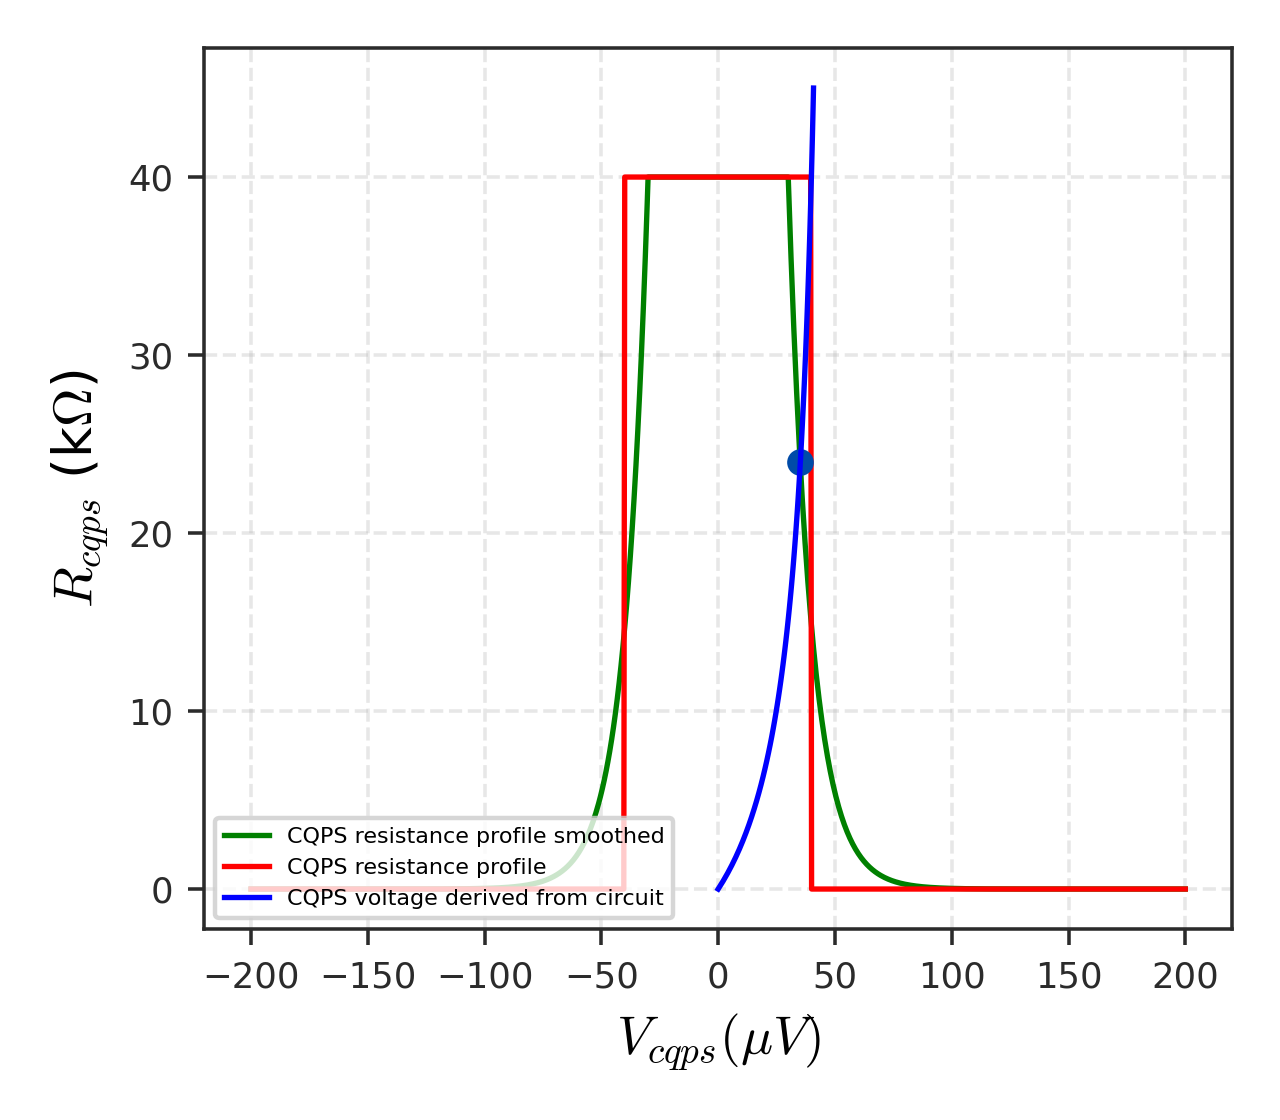

In [184]:
R1 = 1*MOhm
R2 = 100
R_meander = 5*kOhm

V_yokogawa = 500*mV

# The CQPS resistance if it was just on it's own
_voltage = np.linspace(-200*uV, 200*uV, 1001)
R_cqps = np.array(list(map(R_cqps_profile, _voltage)))
R_cqps_smooth = np.array(list(map(R_cqps_profile_smooth,
                                  _voltage)))


# Assuming that we know the resistance of the CQPS, see what voltage develops int he circuit
_R_cqps = np.linspace(0, 45*kOhm, 101)
voltage_relative = eval_voltages_in_circuit(R1, R2, R_meander, _R_cqps)[1]

# Solution to the above equations
# (V_cqps_solution, R_cqps_solution) = fsolve(func, [0, 40*kOhm], 
#                                             args=(V_yokogawa,
#                                                  R1, R2, R_meander))
(V_cqps_solution, R_cqps_solution) = interesction_locator(
    _voltage, R_cqps_smooth,
    voltage_relative*V_yokogawa, _R_cqps)

fig, ax = plt.subplots(1, 1, figsize=(4,3.5))
ax.plot(_voltage/uV, 
        R_cqps_smooth/kOhm, 
        color="green", 
        label="CQPS resistance profile smoothed")
ax.plot(_voltage/uV, 
        R_cqps/kOhm, 
        color="red", 
        label="CQPS resistance profile")
solution, = ax.plot(V_cqps_solution/uV, R_cqps_solution/kOhm, ms=5, marker='o')

cqps_voltage_graph, = ax.plot(voltage_relative * V_yokogawa/uV, 
                              _R_cqps/kOhm, 
                              color="blue", 
                              label="CQPS voltage derived from circuit")

ax.set_ylabel("$R_{cqps}$ (k$\Omega$)", fontsize=12)
ax.set_xlabel("$V_{cqps} (\mu{V})$", fontsize=12)
ax.legend(loc='lower left', fontsize=5)
plt.tight_layout()

In [182]:
def update(V_yokogawa: float):
    V_yokogawa = V_yokogawa*mV
    cqps_voltage_graph.set_xdata(voltage_relative*V_yokogawa/uV)

#     (V_cqps_solution, R_cqps_solution) = fsolve(
#         func,
#         [100*uV, 10*kOhm],
#         args=(V_yokogawa, R1, R2, R_meander))
    (V_cqps_solution, R_cqps_solution) = interesction_locator(
        _voltage, R_cqps_smooth,
        voltage_relative*V_yokogawa, _R_cqps)
    solution.set_data(V_cqps_solution/uV, R_cqps_solution/kOhm)

    ax.relim()
    ax.autoscale_view()
    plt.tight_layout()


V_widget = ipywidgets.FloatSlider(
    min=0, max=2500, step=1,
    description="$V_{yokogawa} (mV)$", value=V_yokogawa/mV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)

ui = ipywidgets.GridspecLayout(3, 1)
ui[0, 0] = V_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "V_yokogawa": V_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatSlider(value=500.0, description='$V_{yokogawa} (mV)$', layout=Layout(grid_area='…

Output()

### I-V Plot

In [194]:
# apply different bias voltages from the Yokogawa and measure the resistance on the CQPS
V_yokogawa = np.linspace(-4000*mV, 4000*mV, 4001)
R1 = 1*MOhm
R2 = 100
R_meander = 5*kOhm

# CQPS resistance profile
_voltage = np.linspace(-200*uV, 200*uV, 1001)
R_cqps_smooth = np.array(list(map(R_cqps_profile_smooth, _voltage)))

# Voltage distribution profile
_R_cqps = np.linspace(0, 45*kOhm, 101)
voltage_relative = eval_voltages_in_circuit(R1, R2, R_meander, _R_cqps)[1]

# Find intersection of the two lines (like in graph above) under different V_yokogawa biase
R_cqps = np.array([interesction_locator(
    _voltage, R_cqps_smooth,
    voltage_relative*vy, _R_cqps
) for vy in V_yokogawa])[:, 1]

# # Repeat numerical solution multiple times, with better and better seeding each time around
# solution_2 = np.array([fsolve(func, [100*uV, r], args=(vy, R1, R2, R_meander)) for (vy, v, r) in zip(V_yokogawa, solution_1[:,0], solution_1[:,1])])
# solution_3 = np.array([fsolve(func, [100*uV, r], args=(vy, R1, R2, R_meander)) for (vy, v, r) in zip(V_yokogawa, solution_2[:,0], solution_2[:,1])])
# solution_4 = np.array([fsolve(func, [100*uV, r], args=(vy, R1, R2, R_meander)) for (vy, v, r) in zip(V_yokogawa, solution_3[:,0], solution_3[:,1])])

<IPython.core.display.Javascript object>


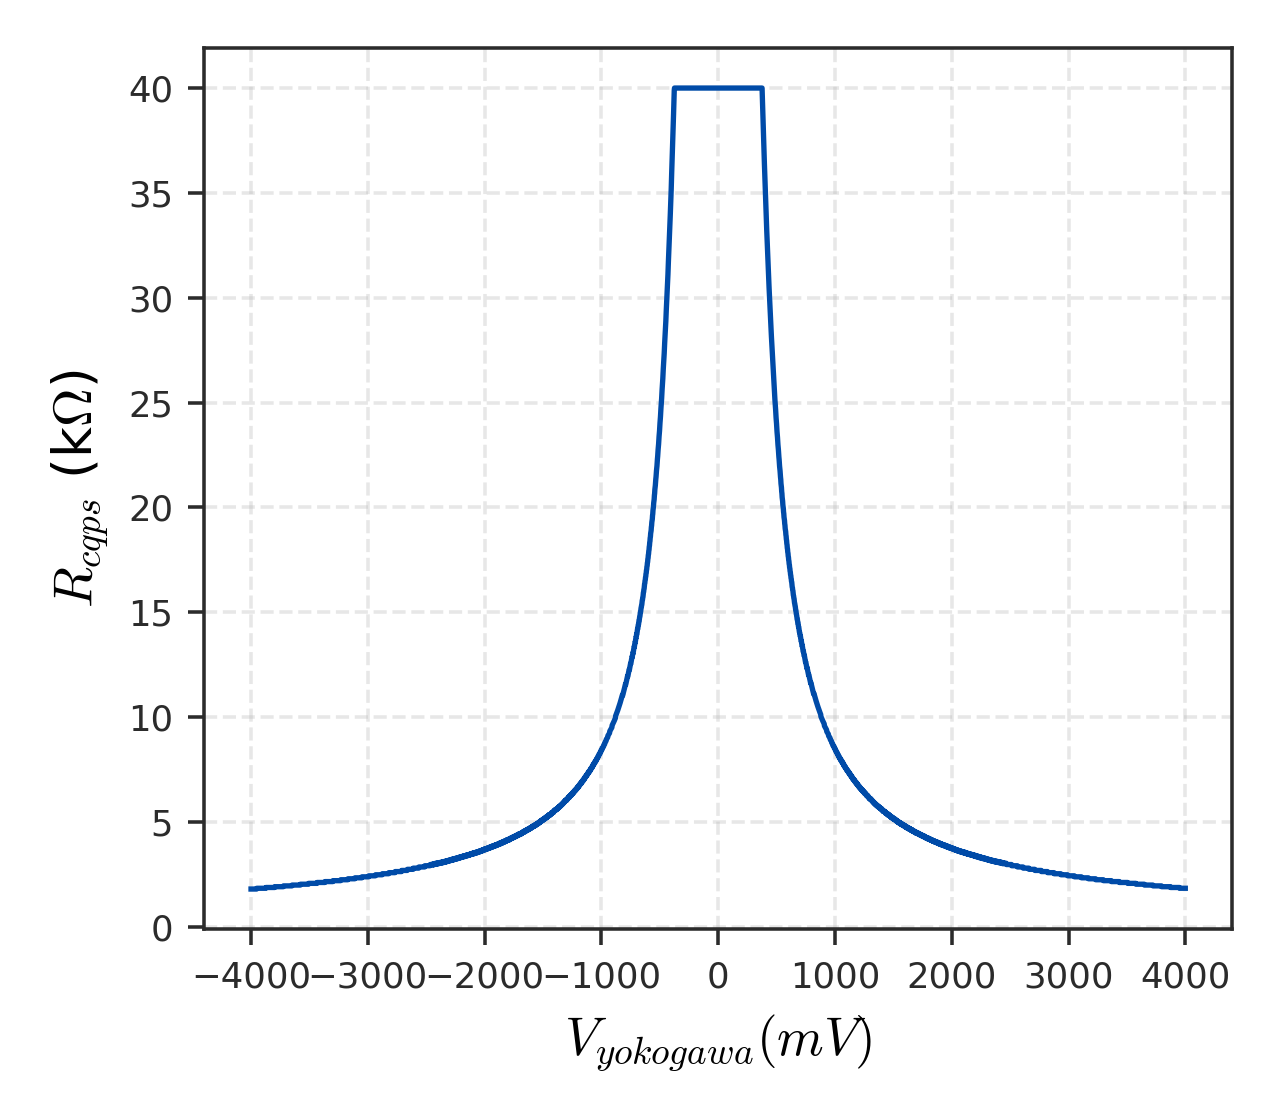

In [195]:
# Display CPQS resistance at different biases
fig, ax = plt.subplots(1, 1, figsize=(4,3.5))
ax.plot(V_yokogawa/mV, 
        R_cqps/kOhm)
ax.set_ylabel("$R_{cqps}$ (k$\Omega$)", fontsize=12)
ax.set_xlabel("$V_{yokogawa} (m{V})$", fontsize=12)
plt.tight_layout()

<IPython.core.display.Javascript object>


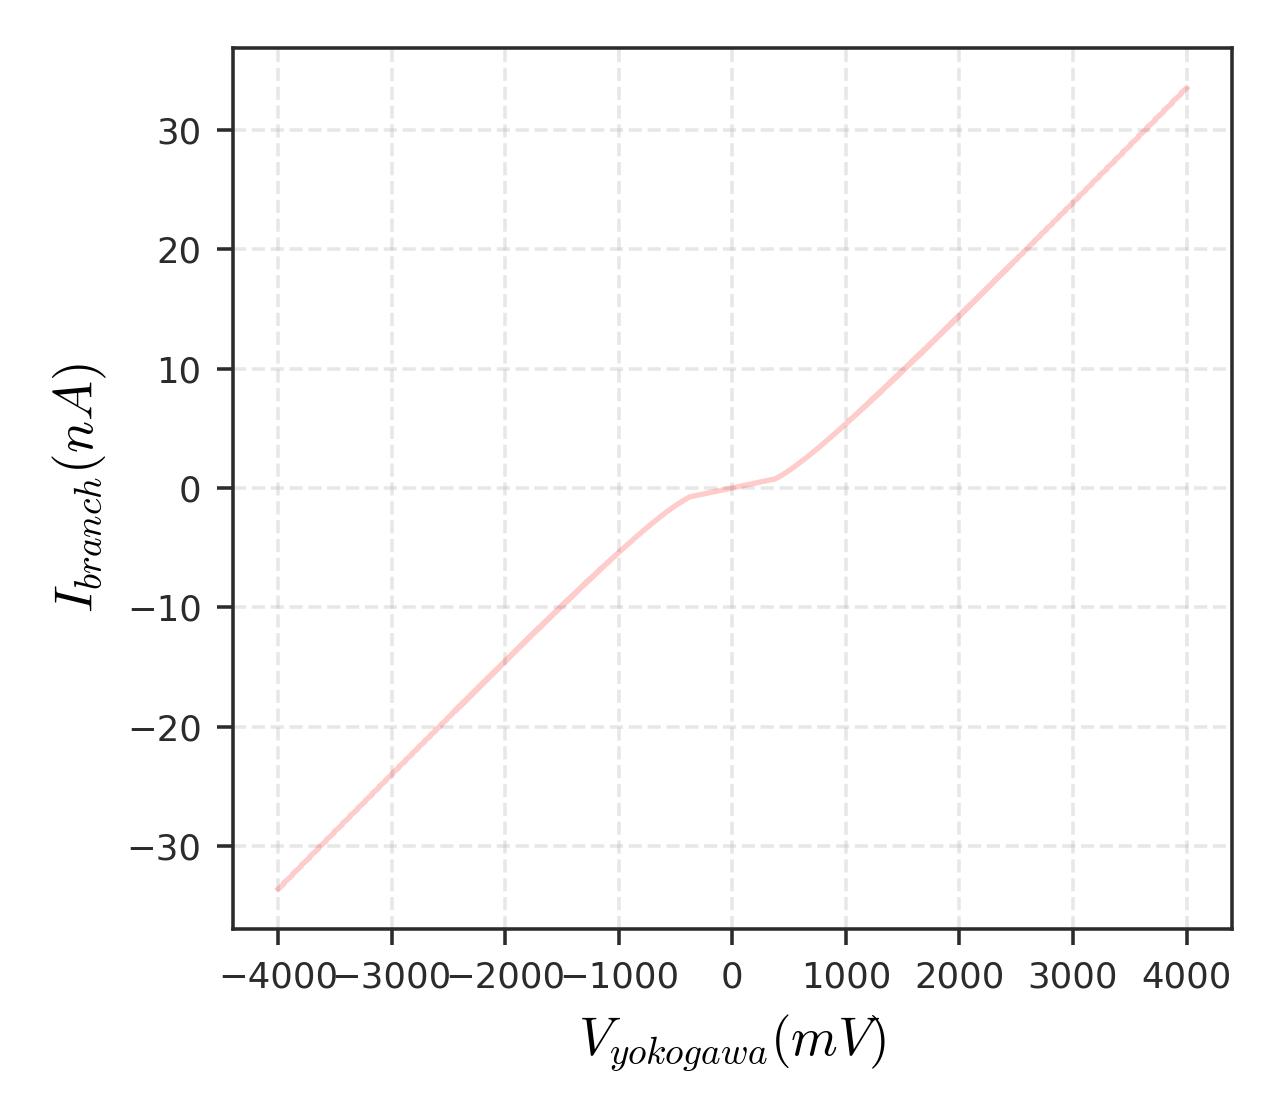

In [192]:
# Now that R_cqps is established, find the voltage across the "branch" and hence the current
voltage_on_branch = V_yokogawa * eval_voltages_in_circuit(R1, R2, R_meander, R_cqps)[0]
resistance_on_branch = R_cqps + 2 * R_meander
current_on_branch = voltage_on_branch / resistance_on_branch

fig, ax = plt.subplots(1, 1, figsize=(4,3.5))
ax.plot(V_yokogawa/mV, 
        current_on_branch/10**(-9),
       color="red", alpha=0.2)
ax.set_ylabel("$I_{branch} (nA)$", fontsize=12)
ax.set_xlabel("$V_{yokogawa} (m{V})$", fontsize=12)
plt.tight_layout()